In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')

In [2]:
from load_dataset import load
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

['acs_income.csv', 'acs_influence 1.ipynb', 'acs_influence all solutions.ipynb', 'acs_influence_new.ipynb', 'adult.data', 'adult.test', 'adult_influence 1.ipynb', 'adult_influence copy.ipynb', 'classifier.py', 'compas-scores-two-years.csv', 'compas_influence 1.ipynb', 'compas_influence.ipynb', 'config.json', 'entropy_test.ipynb', 'expl.py', 'functions.py', 'german.data', 'german_influence 1 copy.ipynb', 'german_influence 1.ipynb', 'german_influence.ipynb', 'influence.py', 'influence_functions.ipynb', 'load_dataset.py', 'loss.py', 'metrics.py', 'meu_test.ipynb', 'random_influence.ipynb', 'sqf_influence 1.ipynb', 'sqf_influence.ipynb', 'sqf_test.csv', 'sqf_train.csv', 'utils.py', '__pycache__']


In [3]:
#Function to run the logistic regression model based on classifier.py
def lr_model(training_df, test_attr_df, classifier):
    changed_df_labels = training_df.pop('is_recid')
    changed_df_attr = training_df.to_numpy()

    classifier.fit(changed_df_attr,changed_df_labels.values)
    y_predicted = classifier.predict_proba(test_attr_df)

    training_df['is_recid'] = changed_df_labels

    return y_predicted


<h4>Removal Based Influence Calculation<h4>

In [4]:
dataset = 'compas'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [5]:
X_train, X_test, y_train, y_test = load(dataset)

In [6]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [7]:
# ensuring that 1 is favorable.
y_train = 1 - y_train

In [8]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
predictors = ['event', 'priors_count', 'juv_other_count', 'juv_misd_count',
       'juv_fel_count', 'race', 'age_cat', 'sex', 'score_text']
target_var =['is_recid']

In [10]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train, columns = predictors)
train_outcome_df = y_train.to_frame()
#train_outcome_df=train_outcome_df.rename(columns={'credit':'credit_risk'})
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [11]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [12]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.10727925675760025
Initial TPR parity:  -0.04645962689765579
Initial predictive parity:  0.053294977119753506
Initial accuracy:  0.09147609147609148


<h2>MEU<h2>

In [13]:
#copy of training data
meu_training_df = train_full_df.copy()

In [14]:
#get the predicted probabilities of the original label
orig_meu_prob = clf.predict_proba(X_train)

In [15]:
#Grab the original of the DP in the copy dataframe and sotre in lists along with the index
label = []
row_index = []
for index, row in meu_training_df.iterrows():
    label.append(meu_training_df.at[index,'is_recid'])
    row_index.append(index)

In [16]:
#Calculate the first part of the MEU equation
meu_part1_list = []
for index, value in enumerate(label):
    if value == 1:
        prob1 = orig_meu_prob[index]
        meu_part1_calc = prob1 * spd_0
        meu_part1_list.append(meu_part1_calc)
    elif value == 0:
        prob2 = orig_meu_prob[index]
        meu_part1_calc = prob2 * spd_0
        meu_part1_list.append(meu_part1_calc)

<h4>MEU Part 2<h4>

In [17]:
#fresh copy of data with flipped label
flipped_train_demo_df = pd.DataFrame(X_train, columns = predictors)
flipped_train_outcome_df = y_train.to_frame()
#flipped_train_outcome_df=flipped_train_outcome_df.rename(columns={'credit':'credit_risk'})
flipped_train_full_df = pd.concat([flipped_train_demo_df, flipped_train_outcome_df], axis=1)

In [18]:
#predict probabilities on the X_train but then do 1-value on each value to get the flipped probability
flipped_meu_prob = clf.predict_proba(X_train)
flipped_meu_prob = 1 - flipped_meu_prob

In [19]:
#flip data labels and re-transform the data
meu_training_df_flipped = flipped_train_full_df.copy()
meu_training_df_flipped['is_recid'] = meu_training_df_flipped['is_recid'].apply(lambda x: 1 if x == 0 else 0)

In [20]:
#Iterate through the copied dataset and flip each lable and calculate the parity

meu_part2_parity_list = []

for idx, row in meu_training_df_flipped.iterrows():
    #If the row is positive then flip it to negative
    if row['is_recid'] == 1:
        meu_training_df_flipped.at[index,'is_recid']= 0
        meu_pred = lr_model(meu_training_df_flipped, X_test, clf)
        meu_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_part2_parity_list.append(meu_parity)
        meu_training_df_flipped.at[index,'is_recid'] = 1
    #If negative then flip to positive
    elif row['is_recid'] == 0:
        meu_training_df_flipped.at[index,'is_recid']= 1
        meu_pred = lr_model(meu_training_df_flipped, X_test, clf)
        meu_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_part2_parity_list.append(meu_parity)
        meu_training_df_flipped.at[index,'is_recid'] = 0

In [21]:
#Second part of the calculation by taking the opposite value
meu_part2_list = []
for index, value in enumerate(label):
    if value == 0:
        prob0 = flipped_meu_prob[index]
        meu_part2_calc = prob0 * meu_part2_parity_list[index]
    elif value == 1:
        prob1 = flipped_meu_prob[index]
        meu_part2_calc = prob1 * meu_part2_parity_list[index]
    meu_part2_list.append(meu_part2_calc)

In [22]:
 #Add the two lists together
expected_utility_values = []
for part1, part2 in zip(meu_part1_list, meu_part2_list):
    expected_utility_values.append(part1+part2)

In [23]:
#EU - OG Parity = new ranked values
new_ranked_value = []
for value in expected_utility_values:
    new_ranked_value.append(value - spd_0)

In [24]:
#Rank the values
combined_list = list(zip(new_ranked_value,row_index))
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)
sorted_eu_list, sorted_index_list = zip(*sorted_list)
meu_end = time.time()

In [25]:
#After ranking flip the values
meu_ranked_parity_list = []

for row in range(len(sorted_index_list)):
    row_num = sorted_index_list[row]
    
    if meu_training_df.at[row_num,'is_recid'] == 1:
        meu_training_df.at[row_num, 'is_recid'] = 0
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_ranked_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_ranked_parity_list.append(meu_ranked_parity)
    elif meu_training_df.at[row_num, 'is_recid'] == 0:
        meu_training_df.at[row_num, 'is_recid'] = 1
        meu_pred = lr_model(meu_training_df, X_test, clf)
        meu_ranked_parity = computeFairness(meu_pred, X_test_orig, y_test, 0, dataset)
        meu_ranked_parity_list.append(meu_ranked_parity)

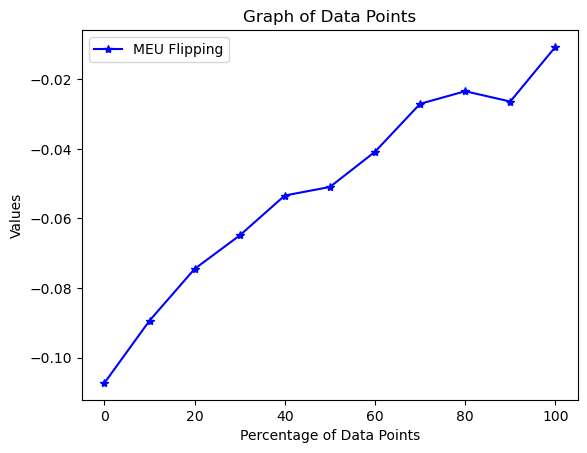

In [26]:
datapoints_meu = len(meu_ranked_parity_list)

#indices at 10 points along the graph
indices = [int(i * datapoints_meu / 10) for i in range(0, 10)]

# Extract the values at these indices
# values_meu = [meu_ranked_parity_list[index] for index in indices]
values_meu = []
values_meu.append(spd_0)
for index in range(1, len(indices) + 1):
    values_meu.append(meu_ranked_parity_list[index * 80 - 1])

#Plot the Values
plt.plot([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], values_meu, label='MEU Flipping', color='Blue', marker = '*')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()